In [1]:
import pandas as pd
import numpy as np
import re
import os

import missingno as msno

#Sklearn
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report, roc_auc_score

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ml-lab-i-c31/data_dictionary.csv
/kaggle/input/ml-lab-i-c31/sample.csv
/kaggle/input/ml-lab-i-c31/train.csv
/kaggle/input/ml-lab-i-c31/test.csv


In [4]:
# To display all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Problem Statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn.

In this competition, your goal is to build a machine learning model that is able to predict churning customers based on the features provided for their usage.

# Reading Datasets

In [5]:
#Reading Dataframes
df = pd.read_csv("../input/ml-lab-i-c31/train.csv", index_col=0)
unseen = pd.read_csv("../input/ml-lab-i-c31/test.csv", index_col=0)
sample = pd.read_csv("../input/ml-lab-i-c31/sample.csv")
data_dict = pd.read_csv("../input/ml-lab-i-c31/data_dictionary.csv")

In [6]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [7]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [8]:
print(df.shape)
df.head()

(69999, 171)


,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.

In [9]:
print(unseen.shape)
unseen.head()

(30000, 170)


,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.0,0.0,0.0,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5,5,4,103,90,60,50,30,30,6/21/2014,7/26/2014,8/24/2014,30,30,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.0,0.0,0

# Dataset Analysis

In [10]:
df.describe()

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69

In [11]:
# Dropping variables with same numeric values in all rows
df = df.drop(columns=['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8',
                      'std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8'])

In [12]:
df.describe(include='object').transpose()

,count,unique,top,freq
last_date_of_month_6,69999,1,6/30/2014,69999
last_date_of_month_7,69600,1,7/31/2014,69600
last_date_of_month_8,69266,1,8/31/2014,69266
date_of_last_rech_6,68898,30,6/30/2014,11880
date_of_last_rech_7,68765,31,7/31/2014,12206
date_of_last_rech_8,67538,31,8/31/2014,10324
date_of_last_rech_data_6,17568,30,6/30/2014,1317
date_of_last_rech_data_7,17865,31,7/31/2014,1282
date_of_last_rech_data_8,18417,31,8/31/2014,1388


In [13]:
# Dropping variables with same unique value in all rows
df = df.drop(columns=['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'])

In [14]:
df.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69999 entries, 0 to 69998
Data columns (total 158 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    arpu_6                    float64
 1    arpu_7                    float64
 2    arpu_8                    float64
 3    onnet_mou_6               float64
 4    onnet_mou_7               float64
 5    onnet_mou_8               float64
 6    offnet_mou_6              float64
 7    offnet_mou_7              float64
 8    offnet_mou_8              float64
 9    roam_ic_mou_6             float64
 10   roam_ic_mou_7             float64
 11   roam_ic_mou_8             float64
 12   roam_og_mou_6             float64
 13   roam_og_mou_7             float64
 14   roam_og_mou_8             float64
 15   loc_og_t2t_mou_6          float64
 16   loc_og_t2t_mou_7          float64
 17   loc_og_t2t_mou_8          float64
 18   loc_og_t2m_mou_6          float64
 19   loc_og_t2m_mou_7          float64
 20   loc_

# Visualizing Missing Values In The Dataset

In [15]:
# Finding columns with null values (in percentage)
null_pct = 100*df.isnull().sum()/len(df)
null_pct[null_pct>0]

onnet_mou_6                  3.954342
onnet_mou_7                  3.838626
onnet_mou_8                  5.290076
offnet_mou_6                 3.954342
offnet_mou_7                 3.838626
offnet_mou_8                 5.290076
roam_ic_mou_6                3.954342
roam_ic_mou_7                3.838626
roam_ic_mou_8                5.290076
roam_og_mou_6                3.954342
roam_og_mou_7                3.838626
roam_og_mou_8                5.290076
loc_og_t2t_mou_6             3.954342
loc_og_t2t_mou_7             3.838626
loc_og_t2t_mou_8             5.290076
loc_og_t2m_mou_6             3.954342
loc_og_t2m_mou_7             3.838626
loc_og_t2m_mou_8             5.290076
loc_og_t2f_mou_6             3.954342
loc_og_t2f_mou_7             3.838626
loc_og_t2f_mou_8             5.290076
loc_og_t2c_mou_6             3.954342
loc_og_t2c_mou_7             3.838626
loc_og_t2c_mou_8             5.290076
loc_og_mou_6                 3.954342
loc_og_mou_7                 3.838626
loc_og_mou_8

In [16]:
# Dropping extreme null value columns (over 40%)
df = df.drop(null_pct[null_pct>40].index,1)
df.shape

(69999, 128)

<AxesSubplot:>

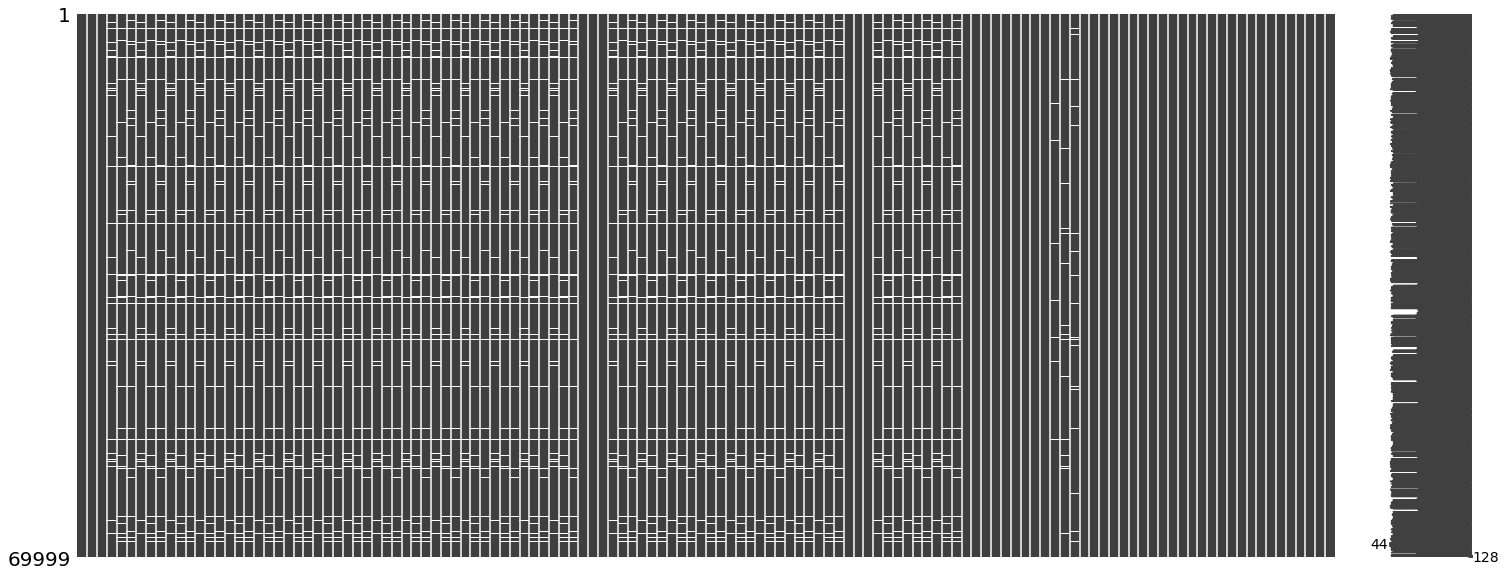

In [17]:
msno.matrix(df)

<AxesSubplot:>

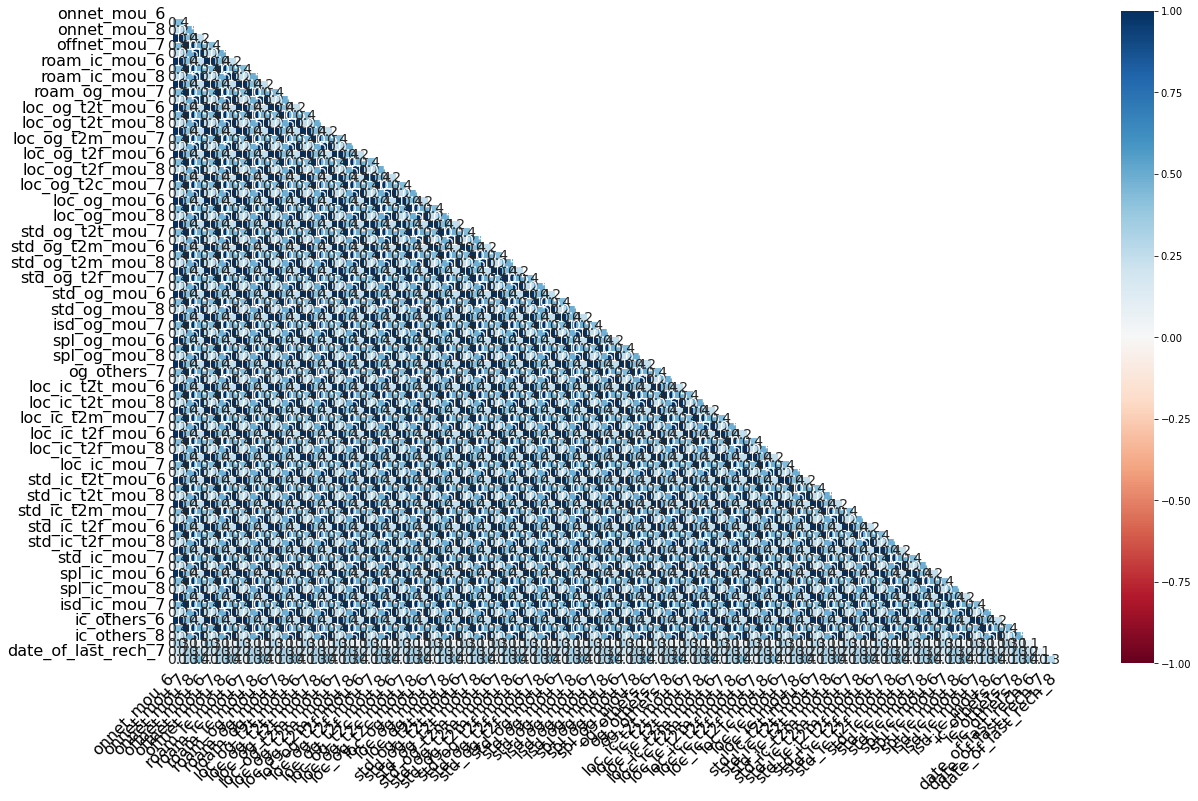

In [18]:
msno.heatmap(df)

<AxesSubplot:>

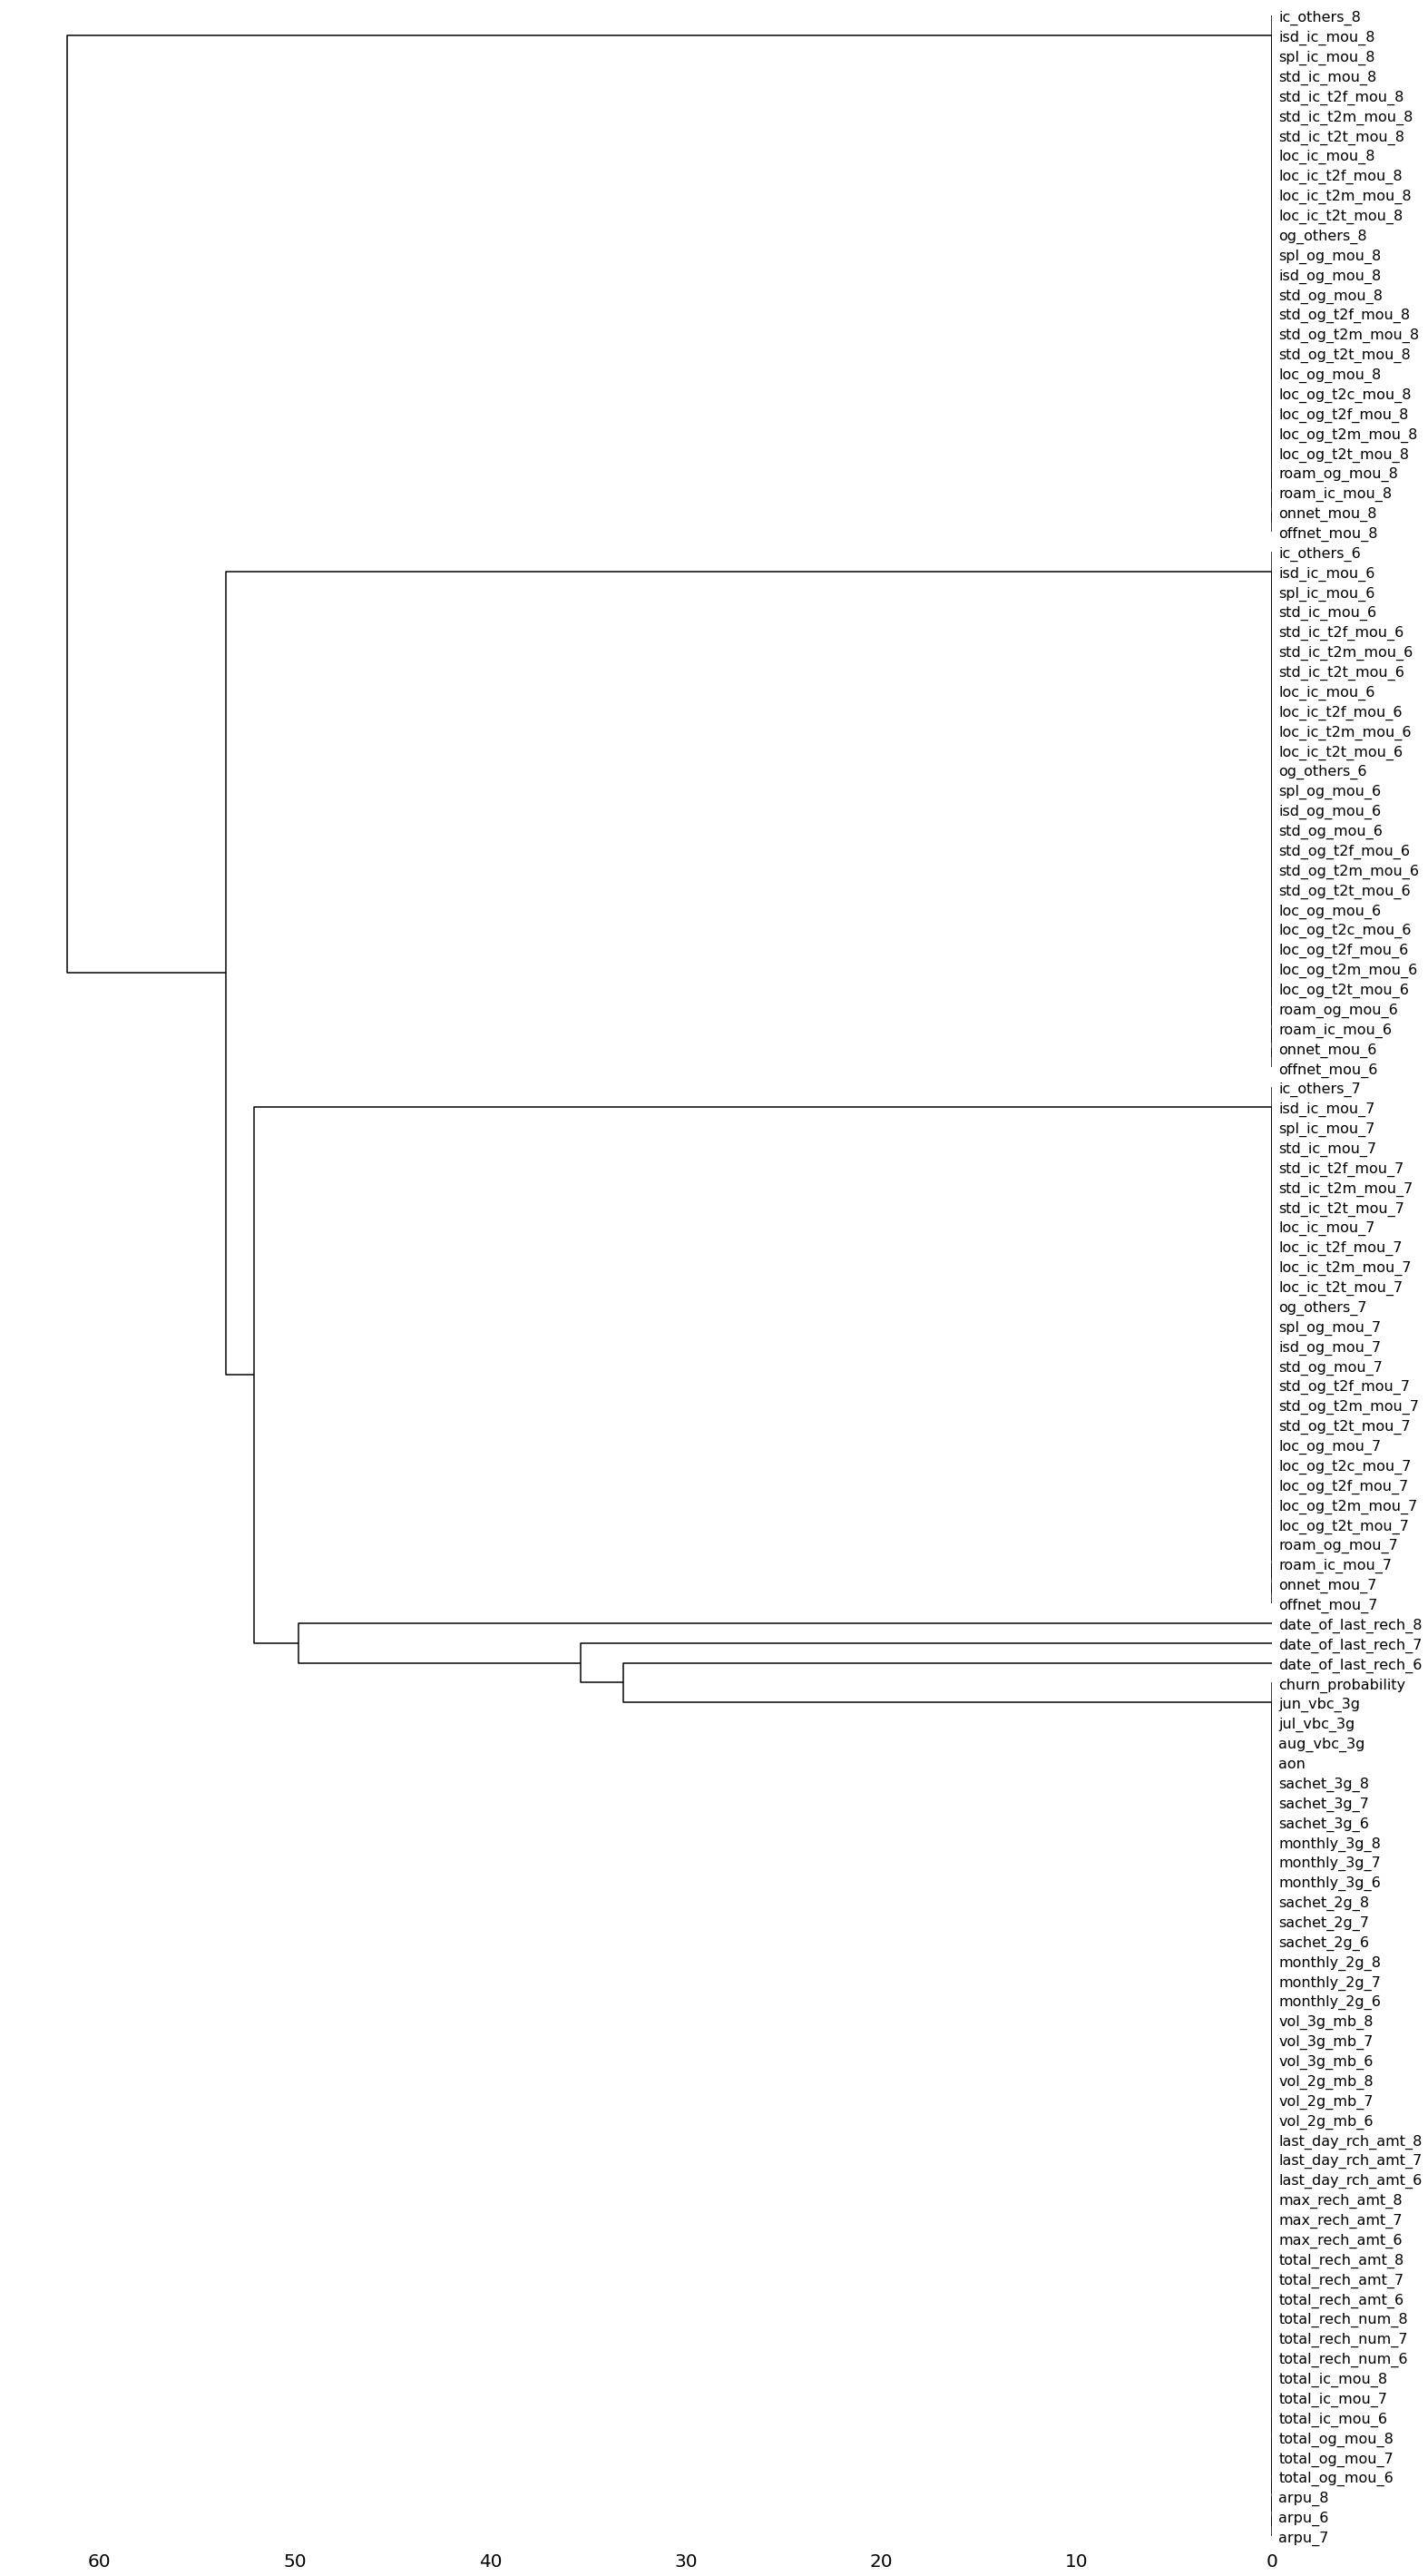

In [19]:
msno.dendrogram(df)

# Visualizing Outliers In Variables With Null

In [20]:
null_pct = 100*df.isnull().sum()/len(df)

In [21]:
# columns with null values
null_cols = null_pct[null_pct>0].index

# numeric & object columns with null values
numeric_null_df = df[null_cols].select_dtypes(exclude='object').columns
obj_null_df = df[null_cols].select_dtypes(include='object').columns

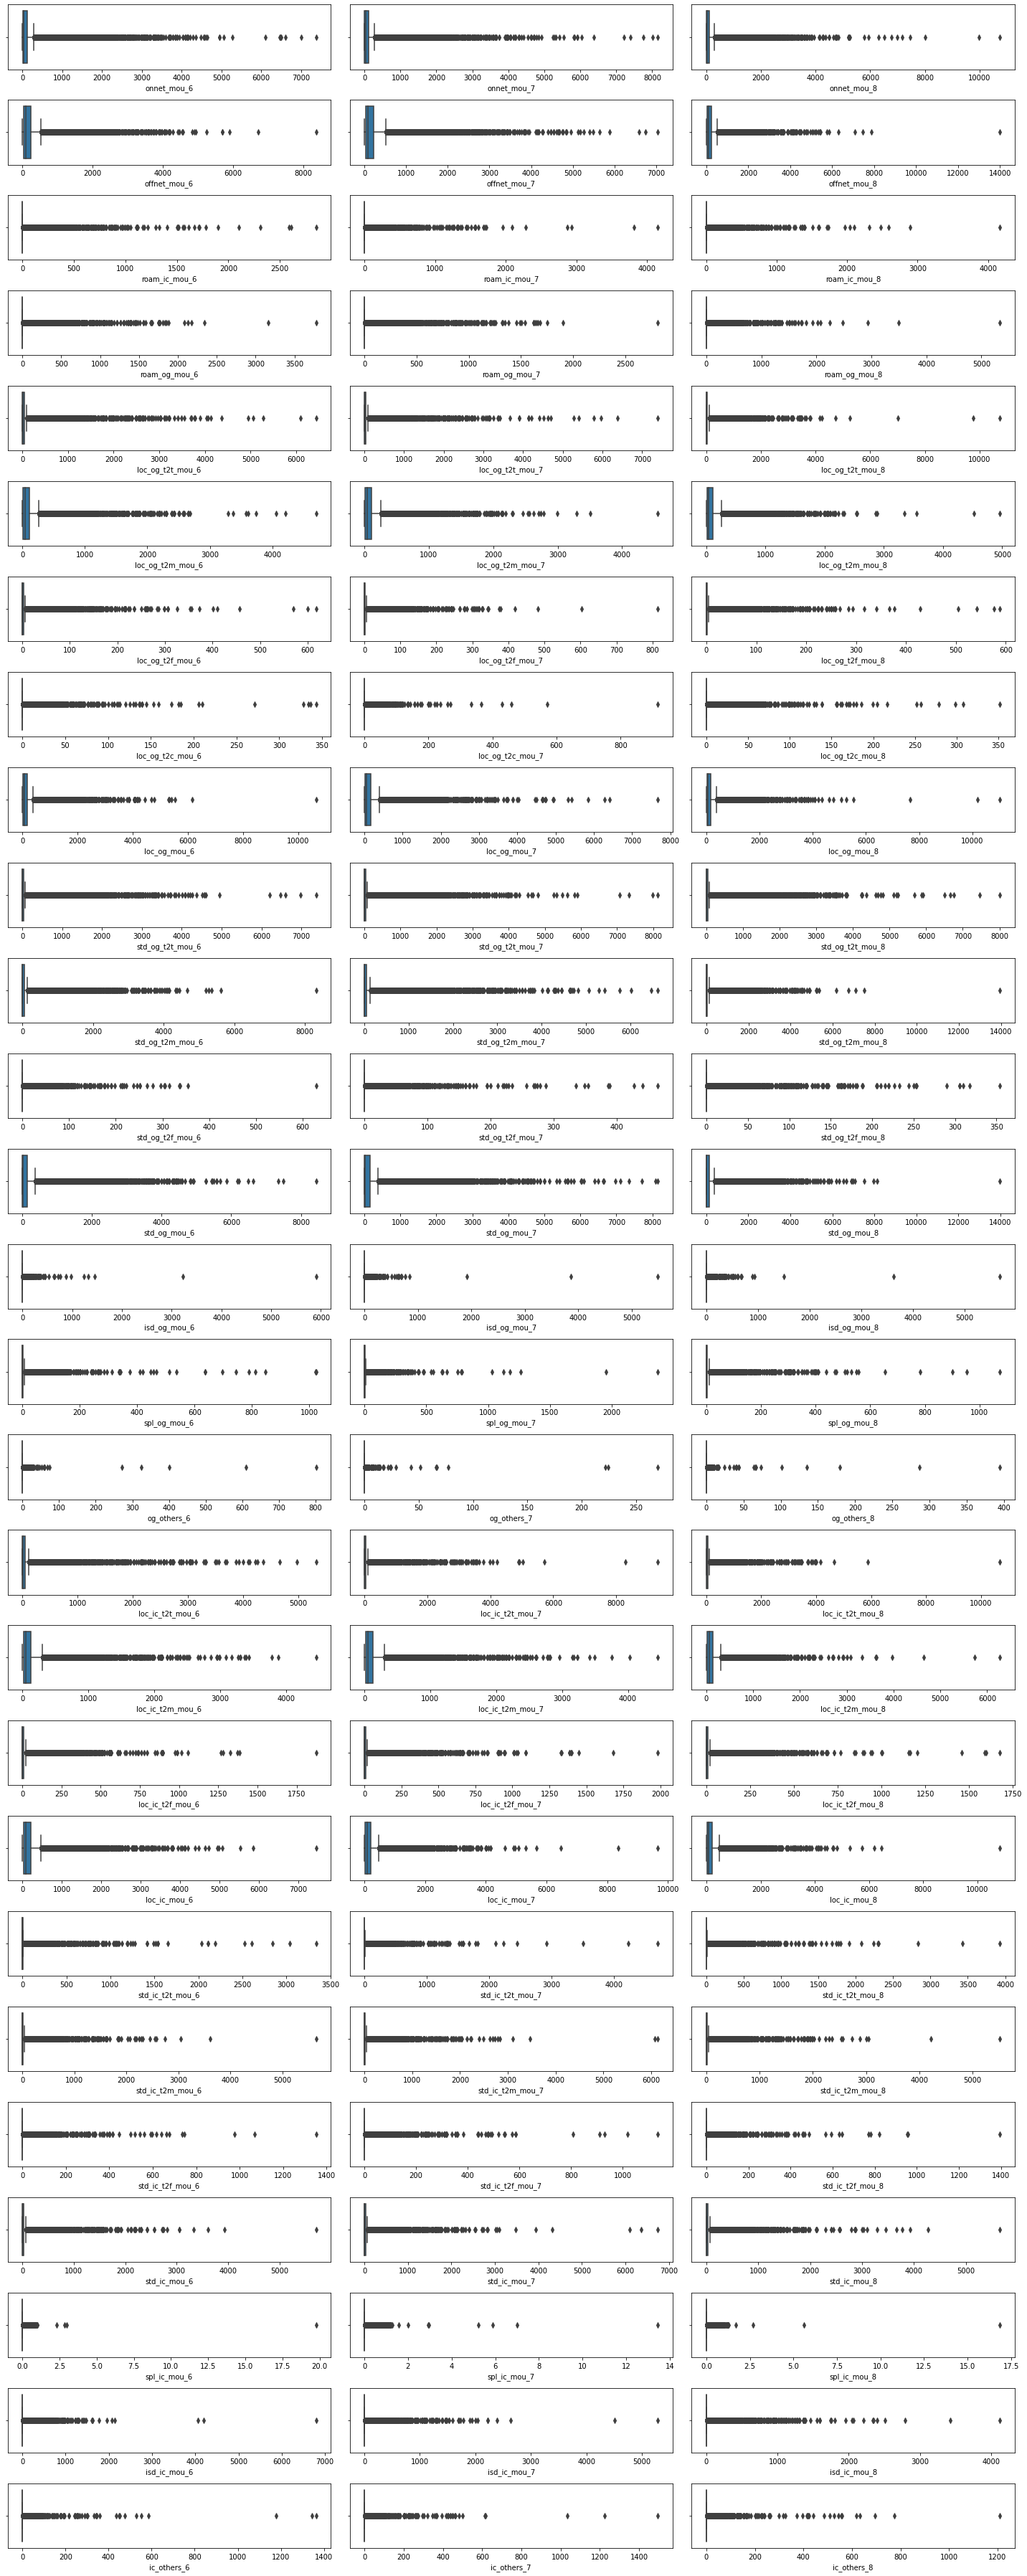

In [22]:
# boxplots to analyze outliers in numeric columns with null values

plt.figure(figsize=(20,50))
n=1
n_rows= round(len(numeric_null_df)/3)

for i in numeric_null_df:
    plt.subplot(n_rows,3,n)
    sns.boxplot(df[i])
    n+=1
    
plt.tight_layout()
plt.show()

**Inference:** Very high number of significant outliers can be observed for all variables with null values.

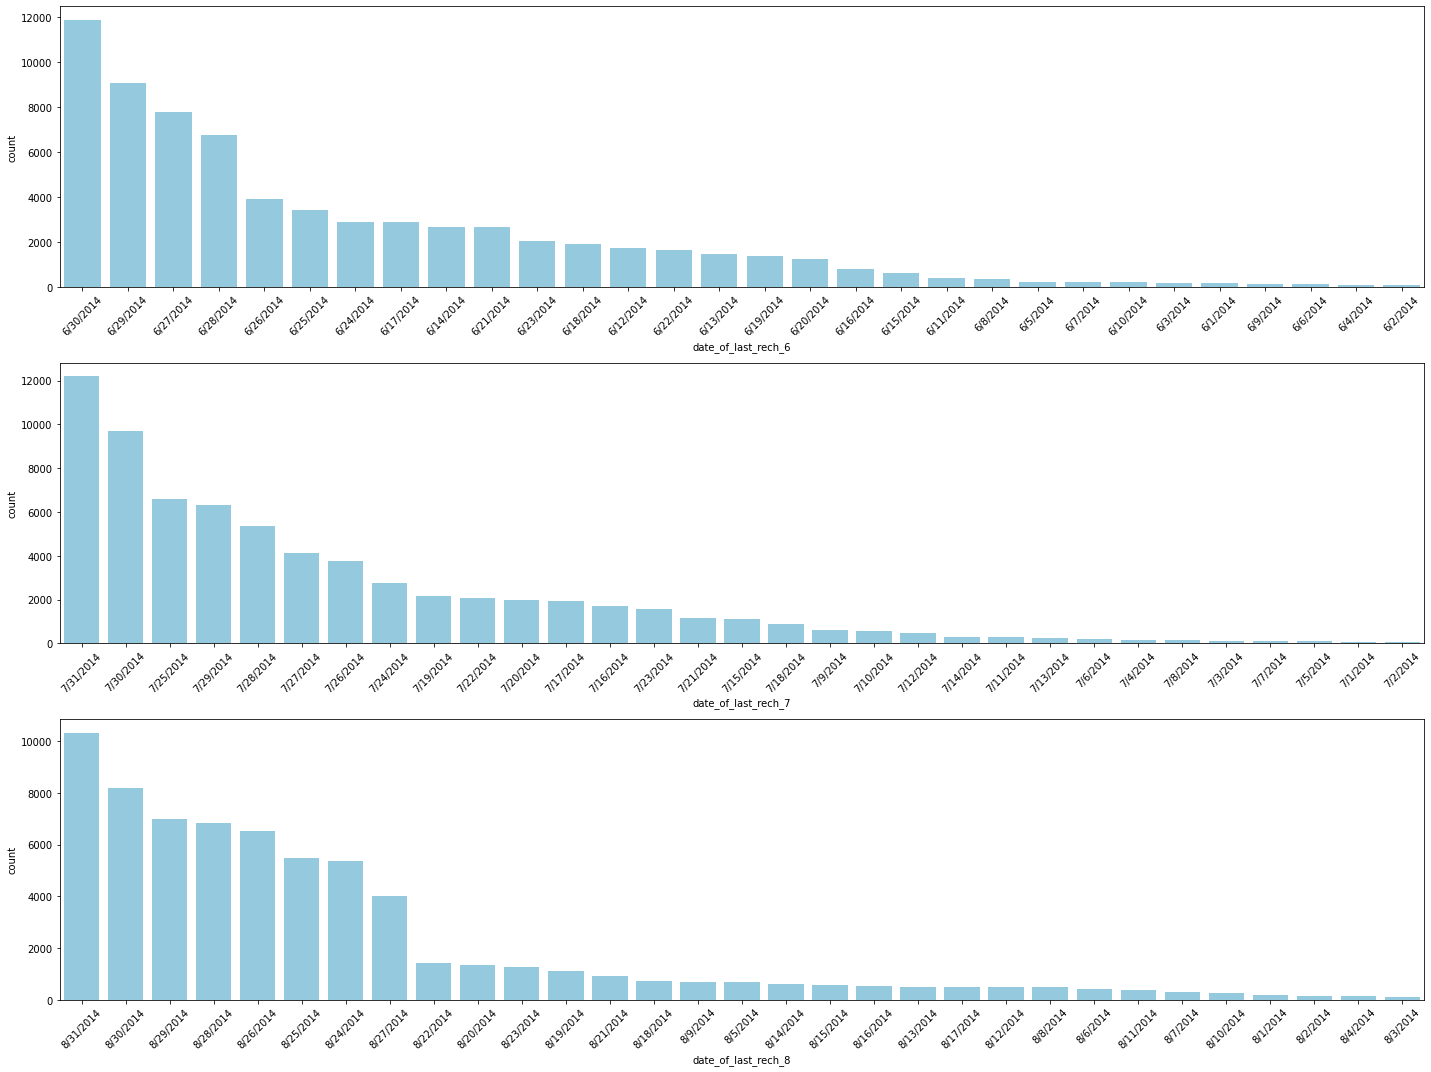

In [23]:
# countplots to analyze distribution of values in categorical columns with null values

n = 1
fig=plt.figure(figsize=(20,15))
for i in obj_null_df:
    plt.subplot(3,1,n)
    sns.countplot(df[i], order=df[i].value_counts().index, color='skyblue')
    plt.xticks(rotation=45)
    n+=1
    
plt.tight_layout()
plt.show()

**Inference:** For all 3 months, it can be observed that significantly higher counts of recharge are taking place in the last few days of the month, while almost negligible counts are seen during first few days.

# Exploratory Data Analysis

In [24]:
# Separating numeric and object variables

num_col_df = df.select_dtypes(exclude='object').copy()
obj_col_df = df.select_dtypes(include='object').copy()

In [25]:
num_col_df.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,65,65,0,0.0,0.00,0.00,0.0,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.0,0.0,0.0,0
1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,0,0,0,0.0,352.91,0.00,0.0,3.96,0.0,0,0,0,0,0,0,0,1,0,0,0,0,710,0.0,0.0,0.0,0
2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.53,12.98,0.00,24.11,0.00,0.00,0.00,0.00,0.00,2.14,0.00,0.00,24.64,12.98,0.00,0.00,2.94,0.00,28.94,82.05,0.0,0.00,0.0,0.0,28.94,84.99,0.00,0.0,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,4.51,6.16,6.49,89.86,25.18,23.51,0.00,0.00,0.00,94.38,31.34,30.01,11.69,0.00,0.00,18.21,2.48,6.38,0.0,0.0,0.0,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,70,50,0,0.0,0.00,0.00,0.0,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,882,0.0,0.0,0.0,0
3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,0.00,0.0,0.0,0.00,0.0,1.63,6.99,3.94,0.00,37.91,44.89,23.63,0.00,0.00,0.00,0.00,0.00,8.03,44.91,48.84,23.63,0.26,12.06,0.00,15.33,25.93,4.6,0.56,0.0,0.0,16.16,37.99,4.60,0.0,0.0,0.0,14.95,9.13,25.61,0.00,0.0,0.0,76.03,95.98,53.84,24.98,4.84,23.88,53.99,44.23,57.14,7.23,0.81,0.00,86.21,49.89,81.03,0.00,0.00,0.00,8.89,0.28,

In [26]:
obj_col_df.head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
id,,,
0,6/22/2014,7/10/2014,8/24/2014
1,6/12/2014,7/10/2014,8/26/2014
2,6/11/2014,7/22/2014,8/24/2014
3,6/15/2014,7/21/2014,8/25/2014
4,6/25/2014,7/26/2014,8/30/2014


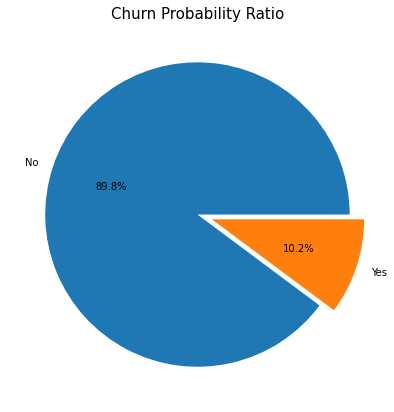

In [27]:
# Plotting Churn Probability Ratio
plt.figure(figsize=(7,7))
plt.pie(df.churn_probability.value_counts(),explode=(0,0.1), labels=['No','Yes'],autopct='%1.1f%%')
plt.title('Churn Probability Ratio',fontsize=15)
plt.show()

**Inference:** Around 10% churn has been observed, at a ratio of 1:9

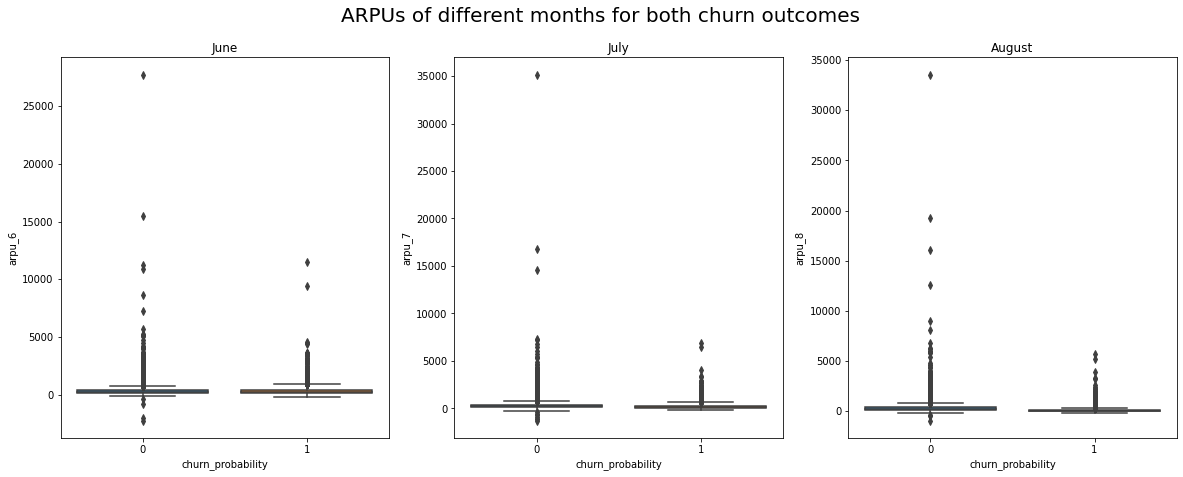

In [28]:
# Plotting ARPUs of different months for both churn outcomes
plt.figure(figsize=(20,7))
plt.suptitle('ARPUs of different months for both churn outcomes', fontsize=20)
plt.subplot(1,3,1)
plt.title('June')
sns.boxplot(y='arpu_6',x='churn_probability',data=df)
plt.subplot(1,3,2)
plt.title('July')
sns.boxplot(y='arpu_7',x='churn_probability',data=df)
plt.subplot(1,3,3)
plt.title('August')
sns.boxplot(y='arpu_8',x='churn_probability',data=df)
plt.show()

**Inference:** Significant outliers are visible in ARPU for both churn and no churn

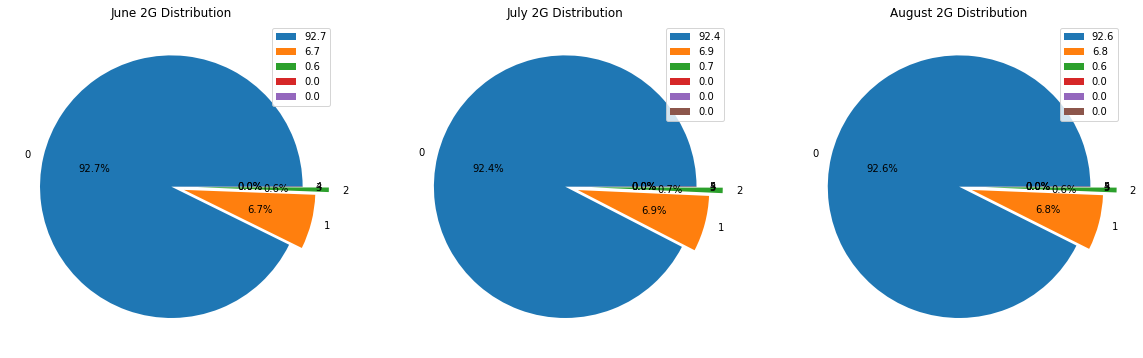

In [29]:

plt.figure(figsize=(20,15))
plt.subplot(1,3,1)
plt.title('June 2G Distribution')
plt.pie(df.monthly_2g_6.value_counts(),explode=(0,0.1,0.2,0,0), labels=['0','1','2','3','4'],autopct='%1.1f%%')
plt.legend(round(df.monthly_2g_6.value_counts(normalize=True)*100,1))
plt.subplot(1,3,2)
plt.title('July 2G Distribution')
plt.pie(df.monthly_2g_7.value_counts(),explode=(0,0.1,0.2,0,0,0), labels=['0','1','2','3','4','5'],autopct='%1.1f%%')
plt.legend(round(df.monthly_2g_7.value_counts(normalize=True)*100,1))
plt.subplot(1,3,3)
plt.title('August 2G Distribution')
plt.pie(df.monthly_2g_8.value_counts(),explode=(0,0.1,0.2,0,0,0), labels=['0','1','2','3','4','5'],autopct='%1.1f%%')
plt.legend(round(df.monthly_2g_8.value_counts(normalize=True)*100,1))
plt.show()

**Inference:** Very high values of 0 can be observed, followed by 1. Rest are negligible in all 3 months.

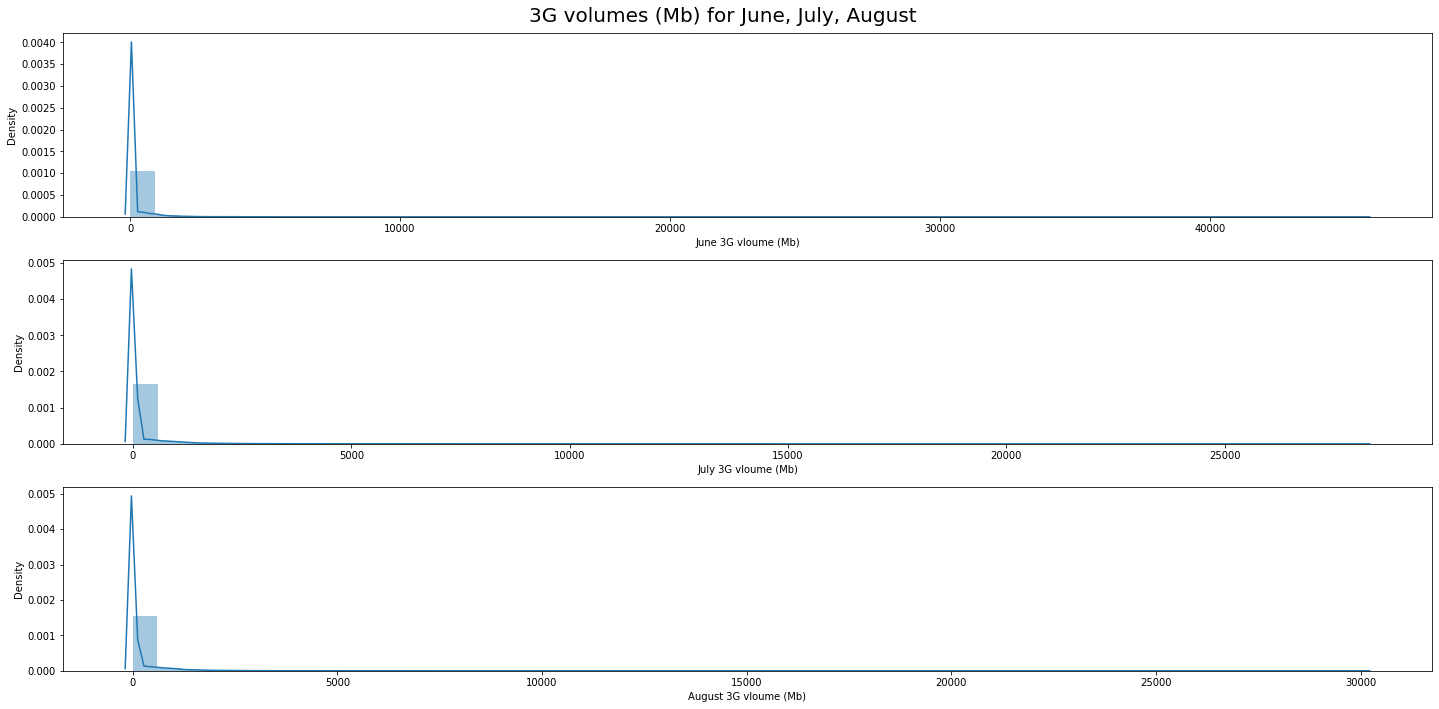

In [30]:
# Plotting 3G volumes (Mb) for June, July, August
plt.figure(figsize=(20,10))
plt.suptitle('3G volumes (Mb) for June, July, August', fontsize=20)
plt.subplot(3,1,1)
sns.distplot(df.vol_3g_mb_6).set(xlabel='June 3G vloume (Mb)')
plt.subplot(3,1,2)
sns.distplot(df.vol_3g_mb_7).set(xlabel='July 3G vloume (Mb)')
plt.subplot(3,1,3)
sns.distplot(df.vol_3g_mb_8).set(xlabel='August 3G vloume (Mb)')
plt.tight_layout()
plt.show()

**Inference:** Very high skewness can be observed in all 3 months

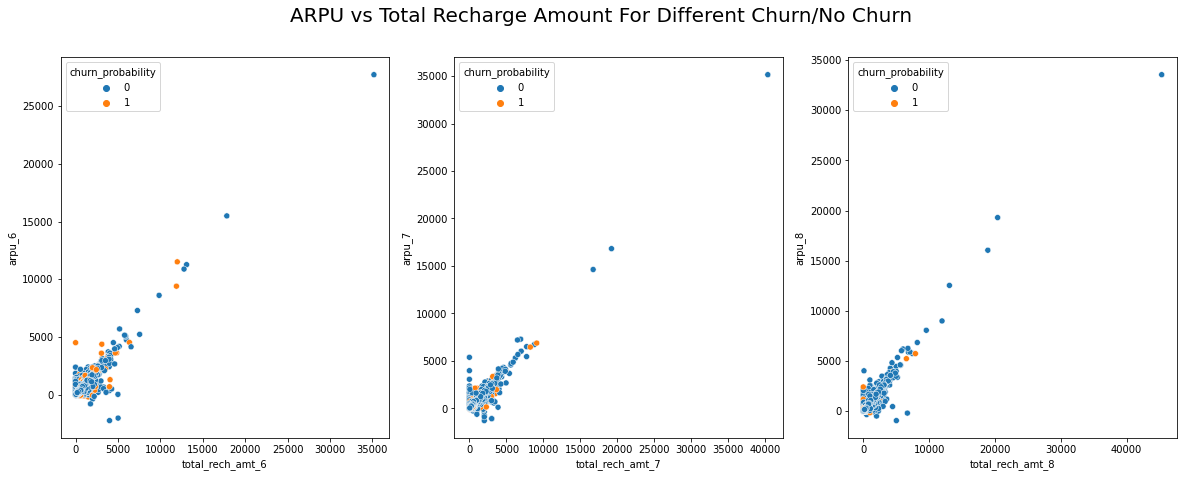

In [31]:
# Plotting ARPU vs Total Recharge Amount For Different Churn/No Churn
plt.figure(figsize=(20,7))
plt.suptitle('ARPU vs Total Recharge Amount For Different Churn/No Churn', fontsize=20)
plt.subplot(1,3,1)
sns.scatterplot(data=df, x='total_rech_amt_6',y='arpu_6',hue='churn_probability')
plt.subplot(1,3,2)
sns.scatterplot(data=df, x='total_rech_amt_7',y='arpu_7',hue='churn_probability')
plt.subplot(1,3,3)
sns.scatterplot(data=df, x='total_rech_amt_8',y='arpu_8',hue='churn_probability')
plt.show()

**Inference:** Extremely high outliers do not show churn, but other than that they are equally distributed among total recharge amount vs arpu, in all three months

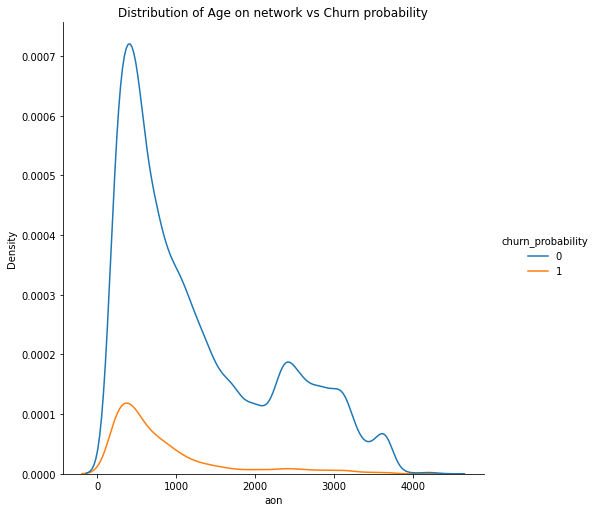

In [32]:
# Plotting distribution of age on network vs Churn probability (0,1)
sns.displot(df, x="aon", hue="churn_probability", kind='kde', height=7).set(title='Distribution of Age on network vs Churn probability')
plt.show()

**Inference:** Skewness can be seen in churns, with majority of churns happening under 1000 aon

## Binning Days In Datetime Variables

In [33]:
# Converting to datetime
df['date_of_last_rech_6'] = pd.to_datetime(df['date_of_last_rech_6'], format='%m/%d/%Y')
df['date_of_last_rech_7'] = pd.to_datetime(df['date_of_last_rech_7'], format='%m/%d/%Y')
df['date_of_last_rech_8'] = pd.to_datetime(df['date_of_last_rech_8'], format='%m/%d/%Y')

# Extracting days of the month 
df['day_of_last_rech_6'] = df['date_of_last_rech_6'].dt.day
df['day_of_last_rech_7'] = df['date_of_last_rech_7'].dt.day
df['day_of_last_rech_8'] = df['date_of_last_rech_8'].dt.day

# Dropping original unnecessary variables
df = df.drop(columns=['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'])

# Binning to Week of the month
cols = ['day_of_last_rech_6','day_of_last_rech_7','day_of_last_rech_8']

for col in cols:
    df[col] = pd.cut(df[col], [0,7,14,21,28,31], labels=['Week 1','Week 2','Week 3','Week 4','Week 5'])

In [34]:
## For unseen dataset
# Converting to datetime
unseen['date_of_last_rech_6'] = pd.to_datetime(unseen['date_of_last_rech_6'], format='%m/%d/%Y')
unseen['date_of_last_rech_7'] = pd.to_datetime(unseen['date_of_last_rech_7'], format='%m/%d/%Y')
unseen['date_of_last_rech_8'] = pd.to_datetime(unseen['date_of_last_rech_8'], format='%m/%d/%Y')

# Extracting days of the month 
unseen['day_of_last_rech_6'] = unseen['date_of_last_rech_6'].dt.day
unseen['day_of_last_rech_7'] = unseen['date_of_last_rech_7'].dt.day
unseen['day_of_last_rech_8'] = unseen['date_of_last_rech_8'].dt.day

# Dropping original unnecessary variables
unseen = unseen.drop(columns=['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'])

# Binning to Week of the month
cols = ['day_of_last_rech_6','day_of_last_rech_7','day_of_last_rech_8']

for col in cols:
    unseen[col] = pd.cut(unseen[col], [0,7,14,21,28,31], labels=['Week 1','Week 2','Week 3','Week 4','Week 5'])

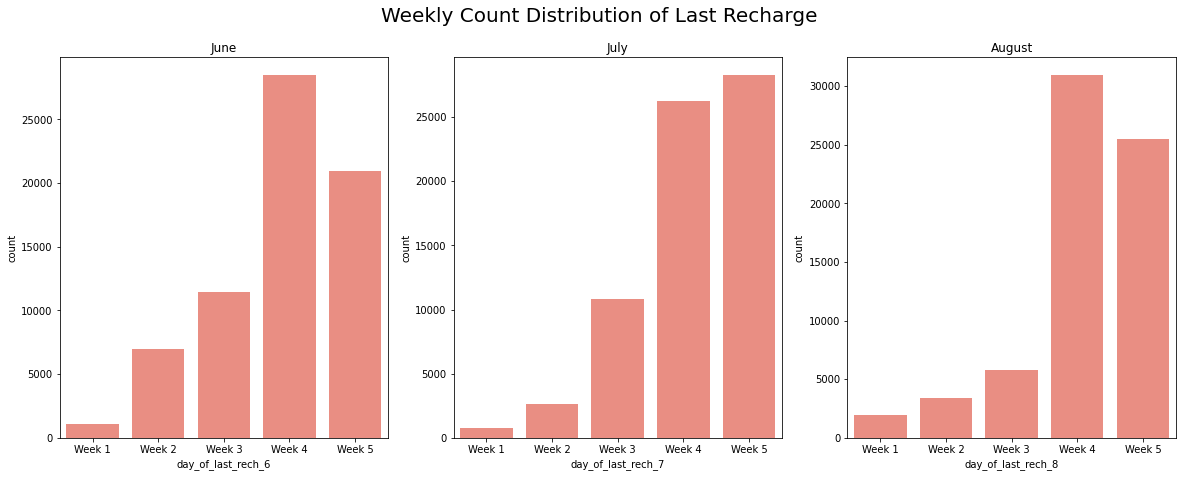

In [35]:
# Plotting again to see last recharge distributions as per week of month

n=1
plt.figure(figsize=(20,7))
plt.suptitle('Weekly Count Distribution of Last Recharge', fontsize=20)
months = ['June','July','August']

for col in cols:
    plt.subplot(1,len(cols),n)
    sns.countplot(df[col], color='salmon')
    plt.title(months[n-1])
    n+=1
    
plt.show()

# Feature Engineering

## New Variables

We will try to observe whether data in last month(8) is increasing or decreasing compared to average of previous two, for different variables

In [36]:
# creating function
def Aug_vs_rest(col1,col2,col3):
    return (df[[col1,col2]].mean(axis=1) >= df[col3]).astype(int)

# ARPU
df['arpu67_8'] = Aug_vs_rest('arpu_6','arpu_7','arpu_8')

# Total outgoing minutes
df['total_og67_8'] = Aug_vs_rest('total_og_mou_6','total_og_mou_7','total_og_mou_8')

# Total incoming min
df['total_ic67_8'] = Aug_vs_rest('total_ic_mou_6','total_ic_mou_7','total_ic_mou_8')

# Total recharge
df['tot_rech_amt67_8'] = Aug_vs_rest('total_rech_amt_6','total_rech_amt_7','total_rech_amt_8')

# Max Recharge
df['max_rech_amt67_8'] = Aug_vs_rest('max_rech_amt_6','max_rech_amt_7','max_rech_amt_8')

# mean of total outgoing vs incoming
df['avg_og_mou'] = df[['total_og_mou_6','total_og_mou_7','total_og_mou_8']].mean(axis=1)
df['avg_ic_mou'] = df[['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8']].mean(axis=1)

# comparing average outgoing is higher or lower than incoming
df['avgIC_>_avgOG'] = (df['avg_ic_mou'] >= df['avg_og_mou']).astype(int)

In [37]:
## For unseen data
# creating function
def Aug_vs_rest(col1,col2,col3):
    return (unseen[[col1,col2]].mean(axis=1) >= unseen[col3]).astype(int)

# ARPU
unseen['arpu67_8'] = Aug_vs_rest('arpu_6','arpu_7','arpu_8')

# Total outgoing minutes
unseen['total_og67_8'] = Aug_vs_rest('total_og_mou_6','total_og_mou_7','total_og_mou_8')

# Total incoming min
unseen['total_ic67_8'] = Aug_vs_rest('total_ic_mou_6','total_ic_mou_7','total_ic_mou_8')

# Total recharge
unseen['tot_rech_amt67_8'] = Aug_vs_rest('total_rech_amt_6','total_rech_amt_7','total_rech_amt_8')

# Max Recharge
unseen['max_rech_amt67_8'] = Aug_vs_rest('max_rech_amt_6','max_rech_amt_7','max_rech_amt_8')

# mean of total outgoing vs incoming
unseen['avg_og_mou'] = unseen[['total_og_mou_6','total_og_mou_7','total_og_mou_8']].mean(axis=1)
unseen['avg_ic_mou'] = unseen[['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8']].mean(axis=1)

# comparing average outgoing is higher or lower than incoming
unseen['avgIC_>_avgOG'] = (unseen['avg_ic_mou'] >= unseen['avg_og_mou']).astype(int)

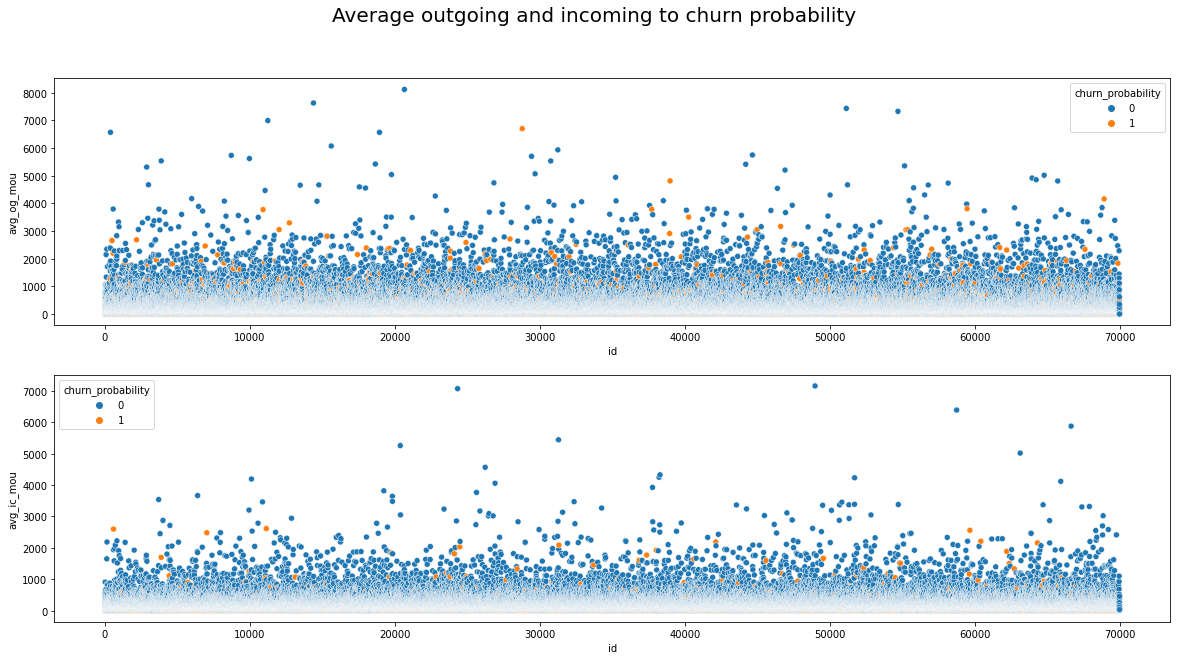

In [38]:
# Plotting average outgoing and incoming to churn probability
plt.figure(figsize=(20,10))
plt.suptitle('Average outgoing and incoming to churn probability', fontsize=20)
plt.subplot(2,1,1)
sns.scatterplot(data=df, y='avg_og_mou',x=df.index, hue='churn_probability')
plt.subplot(2,1,2)
sns.scatterplot(data=df, y='avg_ic_mou',x=df.index, hue='churn_probability')
plt.show()

**Inference:** Lot more churns can be observed  when average outgoing is on the higher side compared to incoming

# Train Test Split

In [39]:
# Changing datatype from category to object for ease of use
df[['day_of_last_rech_6','day_of_last_rech_7','day_of_last_rech_8']] = df[['day_of_last_rech_6','day_of_last_rech_7','day_of_last_rech_8']].astype('object')

In [40]:
# Independent and dependent variable
X=df.drop('churn_probability',1)
y=df.churn_probability

In [41]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((52499, 135), (17500, 135), (52499,), (17500,))

# Preprocessing

In [42]:
# Separating numeric and object variables

num_col_df = X_train.select_dtypes(exclude='object').columns
obj_col_df = X_train.select_dtypes(include='object').columns

## Capping Outliers

In [43]:
# As per our observations in dataframe describe as well as EDA, it is best to cap the variables at 99 and 1 percentile as there are highly skewed outliers

for col in num_col_df:
    percentiles_1_99 = X_train[col].quantile([0.01,0.99]).values
    X_train[col] = np.clip(X_train[col], percentiles_1_99[0], percentiles_1_99[1])
    
for col in num_col_df:
    percentiles_1_99 = X_test[col].quantile([0.01,0.99]).values
    X_test[col] = np.clip(X_test[col], percentiles_1_99[0], percentiles_1_99[1])

In [44]:
# Categorical columns 
categorical_cols = [col for col in X_train if X_train[col].dtype == "object"]

# Numerical columns
numerical_cols = [col for col in X_train if X_train[col].dtype in ['int64', 'float64']]

## Imputation

In [45]:
# Impute numerical variables
imputer = SimpleImputer(strategy='median')
X_train[numerical_cols]=imputer.fit_transform(X_train[numerical_cols])
X_test[numerical_cols]=imputer.transform(X_test[numerical_cols])
unseen[numerical_cols]=imputer.transform(unseen[numerical_cols])

In [46]:
# Impute categorical variables with mode
for col in categorical_cols:
    X_train[col].fillna(X_train[col].mode()[0],inplace=True)
    X_test[col].fillna(X_test[col].mode()[0],inplace=True)
    unseen[col].fillna(unseen[col].mode()[0],inplace=True)

## Create Dummies

In [47]:
X_train = pd.concat([X_train,pd.get_dummies(X_train[categorical_cols],drop_first=True)],axis=1)
X_test = pd.concat([X_test,pd.get_dummies(X_test[categorical_cols])],axis=1)
unseen = pd.concat([unseen,pd.get_dummies(unseen[categorical_cols])],axis=1)

X_train = X_train.drop(columns=['day_of_last_rech_6','day_of_last_rech_7','day_of_last_rech_8'])
X_test = X_test[X_train.columns]
unseen = unseen[X_train.columns]

In [48]:
X_train.shape,X_test.shape,unseen.shape

((52499, 144), (17500, 144), (30000, 144))

# Build Models Using Pipeline

## Logistic Regression model with PCA

In [49]:
# Define the logistic model
lr = LogisticRegression(n_jobs=-1,random_state=0)
scaler = StandardScaler()
pca = PCA(0.90)

pipe_lr = Pipeline(steps=[('scaler',scaler),
                          ('pca',pca),
                          ('model',lr)])

params = [{"model__max_iter": [200,500],
           "model__C": np.logspace(0, 4, 10)}]

search = GridSearchCV(pipe_lr,params,n_jobs=-1,cv=5,verbose=True)

best_model = search.fit(X_train,y_train)

print("Best parameter (CV score=%0.3f):" % best_model.best_score_)
print(best_model.best_params_)
print(best_model.score(X_test,y_test))
print(best_model.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished


Best parameter (CV score=0.915):
{'model__C': 59.94842503189409, 'model__max_iter': 200}
0.9065714285714286
Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.9)),
                ('model',
                 LogisticRegression(C=59.94842503189409, max_iter=200,
                                    n_jobs=-1, random_state=0))])


In [50]:
best_model.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.9)),
                ('model',
                 LogisticRegression(C=59.94842503189409, max_iter=200,
                                    n_jobs=-1, random_state=0))])

In [51]:
confusion_matrix(y_train, best_model.best_estimator_.predict(X_train))

array([[46300,   887],
       [ 3557,  1755]])

In [52]:
confusion_matrix(y_test, best_model.best_estimator_.predict(X_test))

array([[15324,   356],
       [ 1279,   541]])

In [53]:
precision_score(y_test, best_model.best_estimator_.predict(X_test))

0.6031215161649944

In [54]:
recall_score(y_test, best_model.best_estimator_.predict(X_test))

0.29725274725274725

In [55]:
roc_auc_score(y_test, best_model.best_estimator_.predict(X_test))

0.6372743328100472

## RandomForest Classifier Model
To learn about top important features and performance comparision

In [56]:
# Define basic random forest model
rf = RandomForestClassifier(random_state=0,n_jobs=-1,verbose=1)

# Setting hyperparameters
params_rf = {'max_depth': [5,10,25],
             'max_features': [10,15,25],
             'n_estimators': [200,300]}

# model building with 4-fold cv
model_cv = GridSearchCV(estimator=rf, 
                        param_grid=params_rf,
                        verbose=1,
                        n_jobs=-1,
                        return_train_score=True,
                        cv=4)

# Fitting the model with hyperparams and cv
model_cv.fit(X_train,y_train)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   24.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: 

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=0,
                                              verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 25], 'max_features': [10, 15, 25],
                         'n_estimators': [200, 300]},
             return_train_score=True, verbose=1)

In [57]:
#best score from models
model_cv.best_score_

0.9430274771048315

In [58]:
# Build dataframe to see average test and train data to decide hyperparameters of final model
cv_df = pd.DataFrame(model_cv.cv_results_)
cv_df.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
17,271.395617,3.185816,1.457187,0.712642,25,25,300,"{'max_depth': 25, 'max_features': 25, 'n_estim...",0.940038,0.946210,0.943314,0.942548,0.943027,0.002201,1,0.999898,0.999949,0.999822,0.999797,0.999867,0.000061
11,168.308029,0.803976,1.187691,0.176142,10,25,300,"{'max_depth': 10, 'max_features': 25, 'n_estim...",0.939733,0.945676,0.943619,0.943005,0.943008,0.002134,2,0.957789,0.956647,0.958221,0.957232,0.957472,0.000592
9,105.162074,0.398557,1.194207,0.100447,10,15,300,"{'max_depth': 10, 'max_features': 15, 'n_estim...",0.939657,0.946057,0.943695,0.942472,0.942970,0.002306,3,0.954640,0.952989,0.954208,0.953727,0.953891,0.000613
13,106.850461,1.130776,1.660572,0.069688,25,10,300,"{'max_depth': 25, 'max_features': 10, 'n_estim...",0.939810,0.945371,0.943771,0.942472,0.942856,0.002037,4,1.000000,1.000000,0.999975,0.999975,0.999987,0.000013
8,69.128251,0.511701,0.762262,0.047803,10,15,200,"{'max_depth': 10, 'max_features': 15, 'n_estim...",0.939581,0.946057,0.943467,0.942243,0.942837,0.002330,5,0.954818,0.953396,0.954564,0.953473,0.954063,0.000635


**Note:** It can be observed that model #1 has better performance but it has comparatively overfitted the data, so we will choose model #2 for our final build.<br/>
**NB:** Keeping Verbose=1 because the time taken for model build is quite high.

In [59]:
# Final model built after choosing the ideal hyperparameters from the dataframe cv_df
final_model = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=10, max_features=25, oob_score=True, n_estimators=300)

In [60]:
final_model.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, max_features=25, n_estimators=300,
                       n_jobs=-1, oob_score=True, random_state=0)

In [61]:
# Out of bag score
final_model.oob_score_

0.9426274786186404

In [62]:
confusion_matrix(y_train, final_model.predict(X_train))

array([[46513,   674],
       [ 1683,  3629]])

In [63]:
confusion_matrix(y_test, final_model.predict(X_test))

array([[15370,   310],
       [  766,  1054]])

In [64]:
precision_score(y_test, final_model.predict(X_test))

0.7727272727272727

In [65]:
recall_score(y_test, final_model.predict(X_test))

0.5791208791208792

In [66]:
roc_auc_score(y_test, final_model.predict(X_test))

0.779675235478807

**Inference:** It can be seen that this model is better than the logistic regression model in all counts; accuracy, precision, and recall. So we will choose it as the final model for the churn prediction.

# Important Features

In [67]:
# Create dataframe with features and their importance given by the model
feature_names = [cname for cname in X_train.columns]
feature_imp = final_model.feature_importances_

feature_importance = pd.DataFrame(feature_imp)
feature_importance.index = feature_names
feature_importance.columns = ['Importance']

In [68]:
# Top 10 important features
feature_importance.sort_values(by='Importance',ascending=False).head(10)

,Importance
total_ic_mou_8,0.209211
total_og_mou_8,0.121703
arpu_8,0.078897
total_rech_amt_8,0.044901
max_rech_amt_8,0.041860
loc_ic_mou_8,0.030674
last_day_rch_amt_8,0.024444
total_ic_mou_7,0.022182
loc_ic_t2m_mou_8,0.020961
roam_og_mou_8,0.018199


**Inference:** 
* The most important feature that stands out, is total incoming minutes in the last month(August). Business should keep an eye for significant change in this for customers to watchout for churn possibility.
* The second important feature is total outgoing for last month(August). So basically both imcoming and outgoing minutes of last month are very important to predict churn of the customer.
* From top 10 features, 9 of them are from last month(August) which shows that the churn reaction is immediate by the customer in most cases, and not something that has built up over past few months.
* ARPU, Total and Maximum recharge amounts for the last month are also very strong indicators of churn possibility and among the top 5 features.

# Submitting csv for predictions on unseen data

In [69]:
submission_data = unseen[X_train.columns]
submission_data.shape

(30000, 144)

In [70]:
unseen.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,arpu67_8,total_og67_8,total_ic67_8,tot_rech_amt67_8,max_rech_amt67_8,avg_og_mou,avg_ic_mou,avgIC_>_avgOG,day_of_last_rech_6_Week 2,day_of_last_rech_6_Week 3,day_of_last_rech_6_Week 4,day_of_last_rech_6_Week 5,day_of_last_rech_7_Week 2,day_of_last_rech_7_Week 3,day_of_last_rech_7_Week 4,day_of_last_rech_7_Week 5,day_of_last_rech_8_Week 2,day_of_last_rech_8_Week 3,day_of_last_rech_8_Week 4,day_of_last_rech_8_Week 5
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69999,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5.0,5.0,4.0,103.0,90.0,60.0,50.0,30.0,30.0,30.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1692.0,0.00,0.00,0.00,1.0,1.0,1.0,1.0,1.0,67.423333,40.516667,0.0,0,1,0,0,0,0,1,0,0,0,1,0
70000,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,5.0,4.0,5.0,500.0,500.0,500.0,250.0,250.0,250.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2533.0,0.00,0.00,0.00,1.0,1.0,1.0,1.0,1.0,542.836667,305.876667,0.0,0,1,0,0,0,1,0,0,0,0,1,0
70001,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,45.04,22.81,103.38,26.08,24.53,53.68,54.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.

In [71]:
unseen['churn_probability'] = final_model.predict(submission_data)
unseen.reset_index(inplace=True)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,1
3,70002,0
4,70003,0


In [72]:
output.to_csv('tel_churn_nandish_08dec.csv',index=False)